In [8]:
!pip install transformers

In [9]:
import re
import torch

def text_preprocessing(s):
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    return s

In [10]:
text_preprocessing("Md. Shahrin Nakkhatra")

'Md. Shahrin Nakkhatra'

In [11]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        global idx 
        idx += 1
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length= 32,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True  ,    # Return attention mask
            truncation=True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


### Checking our functions with an example batch of size 3

In [12]:
input_ids, attention_masks = preprocessing_for_bert(["Md. Shahrin Nakkhatra", "Hello", "মোঃ শাহরিন নক্ষত্র"]) #

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [13]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import albumentations as A
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from albumentations.pytorch import ToTensor
import matplotlib.pyplot as plt
import pandas as pd

cudnn.benchmark = True

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
df = pd.read_csv('/content/drive/MyDrive/optimizely/model/name_classifier/data/labelled_dataset.csv')

## Fixing class imbalance

In [16]:
df = df.dropna()

In [17]:
df_name = df[df['label']== 1]
df_name.shape

(831514, 3)

In [18]:
df_no_name = df[df['label']== 0]
df_no_name.shape

(2171797, 3)

In [19]:
df_no_name_downsampled = df_no_name.sample(df_name.shape[0])
df_no_name_downsampled.shape

(831514, 3)

In [20]:
df_balanced = pd.concat([df_name, df_no_name_downsampled])
df_balanced.shape

(1663028, 3)

### Taking a portion of the entire dataset (300000 samples in total) as I do not have the resources to train the huge entire dataset

In [21]:
df_balanced_small = df_balanced.sample(300000)
df_balanced_small.shape

(300000, 3)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced_small['name'], df_balanced_small['label'], stratify=df_balanced_small['label'])

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify= y_train)

In [24]:
len(y_train), len(y_val), len(y_test)

(168750, 56250, 75000)

In [25]:
import numpy as np

In [27]:
params = {
    "device": "cuda",
    "lr": 5e-5,
    "batch_size": 32,
    "num_workers": 4,
    "epochs": 5,
    "num_classes": 1
}

In [28]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, params['num_classes']

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [29]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(params):

  model = BertClassifier()

  # Tell PyTorch to run the model on GPU
  model.to(params["device"])

  criterion = nn.BCEWithLogitsLoss().to(params["device"])

  # Create the optimizer
  optimizer = AdamW(model.parameters(),
                    lr= params['lr'],    # Default learning rate
                    eps=1e-8    # Default epsilon value
                    )
  
  total_steps = len(train_dataloader) * params['epochs']
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=0, # Default value
                                              num_training_steps=total_steps)
  
  return model, optimizer, criterion, scheduler

In [30]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [31]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [32]:
def train(train_loader, model, criterion, optimizer, scheduler, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()

    stream = tqdm(train_loader)
    
    for i, (batch) in enumerate(stream, start=1):
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(params['device']) for t in batch)
        b_labels = b_labels.float().view(-1, 1)

        # target = target.to(params["device"], non_blocking=True).float().view(-1, 1)

        output = model(b_input_ids, b_attn_mask)
        loss = criterion(output, b_labels)
        
        accuracy = calculate_accuracy(output, b_labels)

        metric_monitor.update("Loss", loss.item())

        metric_monitor.update("Accuracy", accuracy)

        # brack prop
      
        model.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg']

In [33]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()

    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, batch in enumerate(stream, start=1):
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(params['device']) for t in batch)
            b_labels = b_labels.float().view(-1, 1)
            # target = target.to(params["device"], non_blocking=True).float().view(-1, 1)

            output = model(b_input_ids, b_attn_mask)
            loss = criterion(output, b_labels)
            
            accuracy = calculate_accuracy(output, b_labels)

            metric_monitor.update("Loss", loss.item())

            metric_monitor.update("Accuracy", accuracy)
  
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    # print(metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg'])
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg']

In [34]:
def model_save(epoch, model, optimizer, PATH):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, PATH)

In [35]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(np.array(y_train))
val_labels = torch.tensor(np.array(y_val))
test_labels = torch.tensor(np.array(y_test))

train_inputs, train_masks = preprocessing_for_bert(list(np.array(X_train)))
val_inputs, val_masks = preprocessing_for_bert(list(np.array(X_val)))
test_inputs, test_masks = preprocessing_for_bert(list(np.array(X_test)))

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=params["batch_size"])

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=params["batch_size"])

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=params["batch_size"])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [36]:
# Checking a single iteration for sanity check
# # model, optimizer, criterion, scheduler = initialize_model(params)
# model = BertClassifier()

# # Tell PyTorch to run the model on GPU
# model.to(params["device"])

# criterion = nn.BCEWithLogitsLoss().to(params["device"])

# # Create the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr= params['lr'],    # Default learning rate
#                   eps=1e-8    # Default epsilon value
#                   )

# total_steps = len(train_dataloader) * params['epochs']
# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                             num_warmup_steps=0, # Default value
#                                             num_training_steps=total_steps)

# b_input_ids, b_attn_mask, b_labels = next(iter(train_dataloader))
# b_labels = b_labels.float().view(-1, 1)
# # target = target.to(params["device"], non_blocking=True).float().view(-1, 1)

# output = model(b_input_ids, b_attn_mask)
# loss = criterion(output, b_labels)

# accuracy = calculate_accuracy(output, b_labels)

# # brack prop

# model.zero_grad()
# loss.backward()
# optimizer.step()
# scheduler.step()

In [37]:
bert_classifier, optimizer, criterion, scheduler = initialize_model(params)
# bert_classifier, optimizer, criterion, scheduler

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be r

In [38]:
train_losses = []
train_acc = []

val_losses = []
val_acc = []

prev_accuracy = 0
prev_loss = 2**31-1
best_epoch = 0
prev_best_epoch = 0

for epoch in range(1, params["epochs"] + 1):
    train_loss, train_accuracy = train(train_dataloader, bert_classifier, criterion, optimizer, scheduler, epoch, params)
    val_loss, val_accuracy = validate(val_dataloader, bert_classifier, criterion, epoch, params)

    # Saving the weights only if validation accuracy increases by 8% or validation loss decreases by 5%
    if (val_accuracy >= (prev_accuracy * 1.08))  or (val_loss <= (prev_loss * 1.05)) or (val_accuracy>= prev_accuracy and val_loss<= prev_loss):
        best_epoch = epoch
        model_save(epoch, bert_classifier, optimizer, PATH = f"/content/drive/MyDrive/optimizely/weights/300k-32BS-multilingual-encoder-froze.pth")

    prev_best_epoch = epoch 
    prev_accuracy = val_accuracy
    prev_loss = val_loss

    train_losses.append(train_loss)

    train_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

Epoch: 1. Train.      Loss: 0.290 | Accuracy: 0.892: 100%|██████████| 5274/5274 [18:46<00:00,  4.68it/s]
Epoch: 1. Validation. Loss: 0.253 | Accuracy: 0.913: 100%|██████████| 1758/1758 [01:47<00:00, 16.31it/s]
Epoch: 2. Train.      Loss: 0.224 | Accuracy: 0.923: 100%|██████████| 5274/5274 [18:48<00:00,  4.67it/s]
Epoch: 2. Validation. Loss: 0.252 | Accuracy: 0.916: 100%|██████████| 1758/1758 [01:47<00:00, 16.33it/s]
Epoch: 3. Train.      Loss: 0.184 | Accuracy: 0.939: 100%|██████████| 5274/5274 [18:50<00:00,  4.67it/s]
Epoch: 3. Validation. Loss: 0.255 | Accuracy: 0.916: 100%|██████████| 1758/1758 [01:47<00:00, 16.35it/s]
Epoch: 4. Train.      Loss: 0.147 | Accuracy: 0.952: 100%|██████████| 5274/5274 [18:49<00:00,  4.67it/s]
Epoch: 4. Validation. Loss: 0.273 | Accuracy: 0.912: 100%|██████████| 1758/1758 [01:47<00:00, 16.36it/s]
Epoch: 5. Train.      Loss: 0.116 | Accuracy: 0.964: 100%|██████████| 5274/5274 [18:48<00:00,  4.67it/s]
Epoch: 5. Validation. Loss: 0.315 | Accuracy: 0.912: 10

### Stopped training manually as validation loss is increasing and model is going to overfit

### Plotting loss and accuracy curves for train and validation for choosing best weights

In [39]:
best_epoch

3

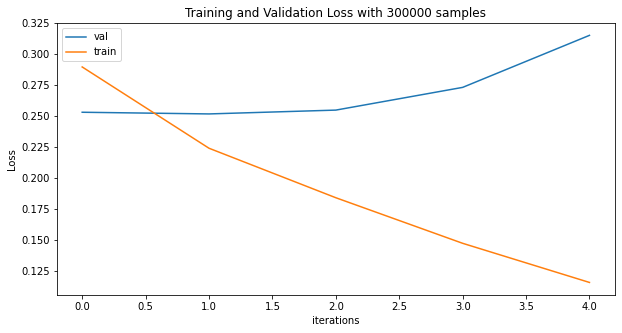

In [40]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss with 300000 samples")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/optimizely/weights/loss_curves_300k.jpg')
plt.show()

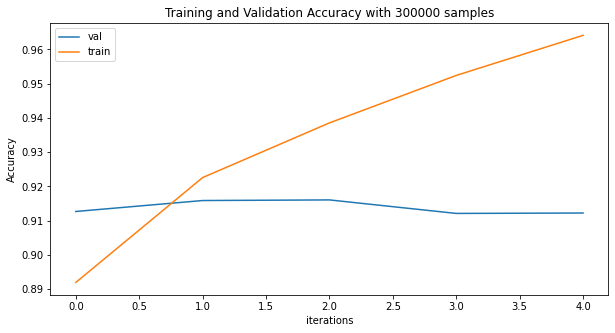

In [41]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy with 300000 samples")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/optimizely/weights/accuracy_curves_300k.jpg')
plt.show()

### Loading saved weights for testing and inference

In [ ]:
from sklearn.metrics import f1_score, precision_score

def calculate_metrics(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    target = target.cpu()
    output = output.cpu()
    
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item(), f1_score(target, output), precision_score(target, output)

def test_pipeline(test_loader, model, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(test_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)

            output = model(images)
            accuracy, f1_score_var, precision = calculate_metrics(output, target)

            metric_monitor.update("Accuracy", accuracy)
            metric_monitor.update("F1-Score", f1_score_var)
            metric_monitor.update("Precision-", precision)
   
            stream.set_description(
                "Epoch: {epoch}. Test. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

    return metric_monitor.metrics['Accuracy']['avg']

In [ ]:
def load_model(weightsdir:str, best_epoch: int):
  model_path = f"{weightsdir}/multilingual-encoder-froze.pth"
  checkpoint = torch.load(model_path, map_location=params['device'])
  bert_classifier.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  return epoch

In [ ]:
loaded_epoch = load_model(weightsdir = '/content/drive/MyDrive/optimizely/weights')

In [ ]:
test_accuracy = test_pipeline(test_dataloader, bert_classifier, loaded_epoch, params)